# Multilayer Neural Networks in TensorFlow


### Goals: 
- Introduce the basics of `TensorFlow`
- Auto-differentiation
- Implement the digit classifier using the low level `TensorFlow` API without Keras abstraction.

# Introduction to TensorFlow

TensorFlow is a dynamic graph computation engine, that allows automatic differentiation of each node. Tensorflow is the default computational backend of the Keras library. I can also be used directly from Python to build deep learning models.

- https://www.tensorflow.org 
- https://www.tensorflow.org/tutorials/quickstart/advanced

TensorFlow builds where nodes may be:
- **constant:** constants tensors, such as training data;
- **Variables:** any tensor that is meant to be updated when training, such as parameters of the models.

**Note** that we are using for this course the new version Tensorflow 2.0. This version cleaned the old cluttered api and uses by default dynamic graph of operations to make it natural to design a model interactively in Jupyter. Previously you defined the graph statically once, and then needed to evaluate it by feeding it some data. Now it is dynamically defined when executing imperative Python instructions which means that you can `print` any tensor at any moment or even use `pdb.set_trace()` to inspect intermediary values.

In [1]:
import tensorflow as tf


a = tf.constant(3)
a

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [2]:
c = tf.Variable(0)
b = tf.constant(2)

c = a + b

c

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [3]:
A = tf.constant([[0, 1], [2, 3]], dtype=tf.float32)
A

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.]], dtype=float32)>

A tf.Tensor can be converted to numpy the following way:

In [4]:
A.numpy()

array([[0., 1.],
       [2., 3.]], dtype=float32)

In [5]:
b = tf.Variable([1, 2], dtype=tf.float32)
b

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 2.], dtype=float32)>

In [6]:
tf.reshape(b, (-1, 1))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [2.]], dtype=float32)>

In [7]:
tf.matmul(A, tf.reshape(b, (-1, 1)))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [8.]], dtype=float32)>

### Exercise

Write a function that computes the squared Euclidean norm of an 1D tensorf input x:

- Use element wise arithmetic operations (`+`, `-`, `*`,  `/`, `**`)
- Use `tf.reduce_sum` to compute the sum of the element of a Tensor.

In [8]:
x = tf.Variable([1, -4], dtype=tf.float32)
x

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 1., -4.], dtype=float32)>

In [13]:
def squared_norm(x):
    # TODO: sum of the squared elements of x
    return tf.reduce_sum(x**2)

In [17]:
# %load solutions/tf_squared_norm.py
def squared_norm(x):
    return tf.reduce_sum(x ** 2)


In [15]:
squared_norm(x)

<tf.Tensor: shape=(), dtype=float32, numpy=17.0>

In [16]:
squared_norm(x).numpy()

17.0

### Autodiff and Gradient Descent

In [18]:
x = tf.Variable([1, -4], dtype=tf.float32)


with tf.GradientTape() as tape:
    result = squared_norm(x)


variables = [x]
gradients = tape.gradient(result, variables)
gradients

[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 2., -8.], dtype=float32)>]

In [19]:
grad_x = gradients[0]

In [20]:
x

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 1., -4.], dtype=float32)>

In [21]:
grad_x

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 2., -8.], dtype=float32)>

We can apply a gradient step to modify x in place by taking one step of gradient descent:

In [521]:
with tf.GradientTape() as tape:
    result = squared_norm(x)
    
grad_x = tape.gradient(result, variables)[0]
x.assign_sub(0.1 * grad_x)
x.numpy()

array([-4.7081756e-38,  4.9368787e-38], dtype=float32)

Execute the following gradient descent step many times consecutively to watch the decrease of the objective function and the values of `x` converging to the minimum of the `squared_norm` function.

Hit `[ctrl]-[enter]` several times to execute the same Jupyter notebook cell over and over again.

In [522]:
with tf.GradientTape() as tape:
    objective = squared_norm(x)
    
x.assign_sub(0.1 * tape.gradient(objective, [x])[0])

print(f"objective = {objective.numpy():e}")
print(f"x = {x.numpy()}")

objective = 0.000000e+00
x = [-4.7081756e-38  4.9368787e-38]


### Device-aware Memory Allocation

To explicitely place tensors on a device, use context managers:

In [524]:
with tf.device("CPU:0"):
    x_cpu = tf.constant(3)
    
with tf.device("GPU:0"):
    x_gpu = tf.constant(3)

x_cpu.device, x_gpu.device

('/job:localhost/replica:0/task:0/device:CPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:0')

## Building a Digits Classifier in TensorFlow

### Dataset:
- Similar as first Lab - Digits: 10 class handwritten digits
- http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits

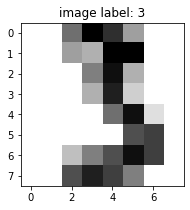

In [525]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()

sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- Normalization
- Train / test split

In [526]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(scaler.mean_)
# print(scaler.scale_)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((1527, 64), (1527,)), ((270, 64), (270,)))

TensorFlow provides dataset abstraction which makes it is to iterate over the data batch by batch:

In [527]:
def gen_dataset(x, y, batch_size=128):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=10000, seed=42)
    dataset = dataset.batch(batch_size=batch_size)
    return dataset

In [528]:
dataset = gen_dataset(X_train, y_train)
dataset

<BatchDataset shapes: ((None, 64), (None,)), types: (tf.float32, tf.int32)>

In [529]:
batch_x, batch_y = next(iter(dataset))
batch_x.shape

TensorShape([128, 64])

In [531]:
 batch_y.shape

TensorShape([128])

### Build a model using TensorFlow

- Using TensorFlow, build a similar model (one hidden layer) as you previously did;
- The input will be a batch coming from X_train, and the output will be a batch of ints;
- The output do not need be normalized as probabilities, the softmax will be moved to the loss function.

In [532]:
# helper functions to use to test your randomly initialized model:

def init_weights(shape):
    return tf.Variable(tf.random.normal(shape, stddev=0.01))


def accuracy(y_pred, y):
    return np.mean(np.argmax(y_pred, axis=1) == y)


def test_model(model, x, y):
    dataset = gen_dataset(x, y)
    preds, targets = [], []
    
    for batch_x, batch_y in dataset:
        preds.append(model(batch_x).numpy())
        targets.append(batch_y.numpy())
     
    preds, targets = np.concatenate(preds), np.concatenate(targets)
    return accuracy(preds, targets)

Define your model there, and then execute the following cell to train your model.
Don't hesitate to tweak the hyperparameters.

In [ ]:
# hyperparams
batch_size = 32
hid_size = 15
learning_rate = 0.5
num_epochs = 10
input_size = X_train.shape[1]
output_size = 10


# build the model and weights
class MyModel:
    def __init__(self, input_size, hid_size, output_size):
        # TODO: randomly initialize all the internal variables of the model:
        self.W_h = None # TODO
        self.b_h = None # TODO
        self.W_o = None # TODO
        self.b_o = None # TODO
        
    def __call__(self, inputs):
        # TODO: this method should implement the forward pass with
        # tensorflow operations: compute the outputs, that is the
        # unnormalized predictions of the network for a give batch
        # of inputs vectors.
        # No need to implement the softmax operations as we will
        # move it the loss function instead.
        
        # Hint: you can use tf.matmul, tf.tanh, tf.sigmoid,
        # arithmetic operations and so on.
        return None
    
model = MyModel(input_size, hid_size, output_size)

In [548]:
# %load solutions/tf_model.py
# hyperparams
batch_size = 32
hid_size = 15
learning_rate = 0.5
num_epochs = 10
input_size = X_train.shape[1]
output_size = 10

# build the model and weights
class MyModel:
    def __init__(self, input_size, hid_size, output_size):
        self.W_h = init_weights([input_size, hid_size])
        self.b_h = init_weights([hid_size])
        self.W_o = init_weights([hid_size, output_size])
        self.b_o = init_weights([output_size])

    def __call__(self, inputs):
        h = tf.nn.sigmoid(tf.matmul(inputs, self.W_h) + self.b_h)
        return tf.matmul(h, self.W_o) + self.b_o

model = MyModel(input_size, hid_size, output_size)


In [549]:
test_model(model, X_test, y_test)

0.1

The following implements a training loop in Python. Note the use of `tf.GradientTape` to automatically compute the gradients of the loss w.r.t. the different parameters of the model:

Epoch 0, train_acc = 0.5894, test_acc = 0.5444
Epoch 1, train_acc = 0.7845, test_acc = 0.7593
Epoch 2, train_acc = 0.8874, test_acc = 0.8815
Epoch 3, train_acc = 0.9352, test_acc = 0.9333
Epoch 4, train_acc = 0.9561, test_acc = 0.9519
Epoch 5, train_acc = 0.9699, test_acc = 0.9519
Epoch 6, train_acc = 0.9764, test_acc = 0.9593
Epoch 7, train_acc = 0.9771, test_acc = 0.9593
Epoch 8, train_acc = 0.9797, test_acc = 0.9556
Epoch 9, train_acc = 0.983, test_acc = 0.9593


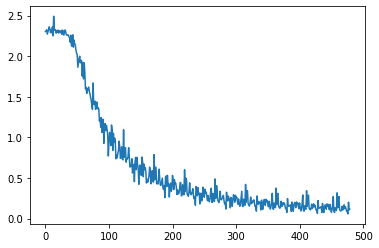

In [550]:
losses = []
for e in range(num_epochs):
    train_dataset = gen_dataset(X_train, y_train, batch_size=batch_size)
    
    for batch_x, batch_y in train_dataset:
        # tf.GradientTape records the activation to compute the gradients:
        with tf.GradientTape() as tape:
            logits = model(batch_x)
            loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(batch_y, logits))
            losses.append(loss.numpy())
            
        # Here we ask for the gradients of dL/dW_h, etc.
        dW_h, db_h, dW_o, db_o = tape.gradient(
            loss, [model.W_h, model.b_h, model.W_o, model.b_o])
        
        # Update the weights as a Stochastic Gradient Descent would do:
        model.W_h.assign_sub(learning_rate * dW_h)
        model.b_h.assign_sub(learning_rate * db_h)
        model.W_o.assign_sub(learning_rate * dW_o)
        model.b_o.assign_sub(learning_rate * db_o)
        
    train_acc = test_model(model, X_train, y_train)
    test_acc = test_model(model, X_test, y_test)
    print("Epoch {}, train_acc = {}, test_acc = {}".format(e, round(train_acc, 4), round(test_acc, 4)))
    
plt.plot(losses)

In [537]:
test_model(model, X_test, y_test)

0.9666666666666667

In [538]:
test_model(model, X_train, y_train)

0.9842829076620825

### Exercises (Bonus)

- add L2 regularization with $\lambda = 10^{-4}$
- train with arbitrary number of layers: only pass the layer sizes as hyperparameter to the model class constructor (`__init__` method)
- try implementing momentum
- you may use tensorboard (https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) to monitor loss and display graph

Epoch 0, train_acc = 0.3497, test_acc = 0.3185
Epoch 1, train_acc = 0.649, test_acc = 0.5889
Epoch 2, train_acc = 0.814, test_acc = 0.7704
Epoch 3, train_acc = 0.8631, test_acc = 0.8519
Epoch 4, train_acc = 0.8893, test_acc = 0.8889
Epoch 5, train_acc = 0.9057, test_acc = 0.9074
Epoch 6, train_acc = 0.9214, test_acc = 0.9185
Epoch 7, train_acc = 0.9319, test_acc = 0.9333
Epoch 8, train_acc = 0.9391, test_acc = 0.9407
Epoch 9, train_acc = 0.9404, test_acc = 0.9444


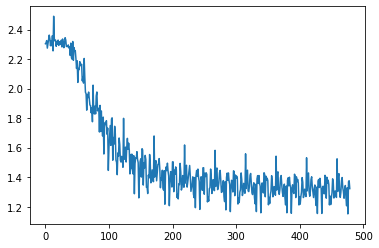

In [556]:
### ADDING L2 REGULARIZATION
model = MyModel(input_size, hid_size, output_size)

lambda_ = 1e-2  # 1e-4
losses = []
for e in range(num_epochs):
    train_dataset = gen_dataset(X_train, y_train, batch_size=batch_size)
    
    for batch_x, batch_y in train_dataset:
        # tf.GradientTape records the activation to compute the gradients:
        with tf.GradientTape() as tape:
            logits = model(batch_x)
            loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(batch_y, logits))
            loss += lambda_ * (tf.reduce_sum(squared_norm(model.W_h)) + tf.reduce_sum(squared_norm(model.W_o)))
            losses.append(loss.numpy())
            
        # Here we ask for the gradients of dL/dW_h, etc.
        dW_h, db_h, dW_o, db_o = tape.gradient(
            loss, [model.W_h, model.b_h, model.W_o, model.b_o])
        
        # Update the weights as a Stochastic Gradient Descent would do:
        model.W_h.assign_sub(learning_rate * dW_h)
        model.b_h.assign_sub(learning_rate * db_h)
        model.W_o.assign_sub(learning_rate * dW_o)
        model.b_o.assign_sub(learning_rate * db_o)
        
    train_acc = test_model(model, X_train, y_train)
    test_acc = test_model(model, X_test, y_test)
    print("Epoch {}, train_acc = {}, test_acc = {}".format(e, round(train_acc, 4), round(test_acc, 4)))
    
plt.plot(losses)

In [551]:
### WITHOUT REG
tf.reduce_mean(model.W_h).numpy()

0.0011431383

In [557]:
### WITH REG
tf.reduce_mean(model.W_h).numpy()

1.6329189e-08